# Project: Investigate Medical Appointment No Shows

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#configuration">Configuration</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. 

1. PatientId - Identification of a patient
2. AppointmentID - Identification of each appointment
3. Gender - Male or Female . Female is the greater proportion, woman takes way more care of they health in comparison to man.
4. ScheduledDay - The day of the actual appointment, when they have to visit the doctor.
5. AppointmentDay - The day someone called or registered the appointment, this is before appointment of course.
6. Age - How old is the patient.
7. Neighbourhood - Where the appointment takes place.
8. Scholarship - True of False . Observation, this is a broad topic, consider reading this article https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia
9. Hipertension - True or False
10. Diabetes - True or False
11. Alcoholism - True or False
12. Handcap - True or False
13. SMS_received - 1 or more messages sent to the patient.
14. No-show - Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

### Analysis 

The project will look into the following features and its impact on the No-Show behavior. The following questions can be tested against the dataset:

1. Does Gender play a part in the show and no-show probability
2. Does Age Group play a part in the show and no-show probability

<a id='configuration'></a>
## Configuration

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbn
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.5f' % x)

<a id='wrangling'></a>
## Data Wrangling

### Load Data

In [2]:
df_raw = pd.read_csv('noshowappointments-kagglev2-may-2016.zip')
df_raw.head(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.00000,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.00000,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.00000,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.00000,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.00000,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Schema

This section looks into the schema of the dataset and correct the schema before performing Data Cleaning

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### Rename columns

The columns are renamed here to use the snake case naming convention for easier manipulation.

In [4]:
def rename_column(column):
    if column == 'No-show':
        return 'no_show'
    
    if column == 'SMS_received':
        return 'sms_received'
    
    if column == 'AppointmentID':
        return 'appointment_id'
    
    return ''.join([
        f'_{c.lower()}' if c.isupper() else c for c in column
    ]).lstrip('_')
    
df_raw.rename(rename_column, axis=1, inplace=True)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   patient_id       110527 non-null  float64
 1   appointment_id   110527 non-null  int64  
 2   gender           110527 non-null  object 
 3   scheduled_day    110527 non-null  object 
 4   appointment_day  110527 non-null  object 
 5   age              110527 non-null  int64  
 6   neighbourhood    110527 non-null  object 
 7   scholarship      110527 non-null  int64  
 8   hipertension     110527 non-null  int64  
 9   diabetes         110527 non-null  int64  
 10  alcoholism       110527 non-null  int64  
 11  handcap          110527 non-null  int64  
 12  sms_received     110527 non-null  int64  
 13  no_show          110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### Convert id columns to correct types

patient_id and appointment_id are unique indentifiers for the records and should not appear in the summary statistics. 

In [5]:
df_raw.patient_id = df_raw.patient_id.astype(int) # This is required to dtop the decimal values from the column
df_raw = df_raw.astype({
    'patient_id': 'str',
    'appointment_id': 'str'
})
df_raw.head(5)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Convert date columns to dates

scheduled_day and appointment_day should be converted to datetime fields

In [6]:
df_raw.scheduled_day = pd.to_datetime(df_raw.scheduled_day)  
df_raw.appointment_day = pd.to_datetime(df_raw.appointment_day)  
df_raw.head(5)

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,29872499824296,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Show duplicates

Checking if there are duplicated appointments by the same patient on the same day

In [7]:
print('Show duplicated records')
display(
    df_raw[
        df_raw.duplicated(['patient_id', 'scheduled_day'])
    ].sort_values(['patient_id', 'scheduled_day'])
)

print('Show subset of duplicated records')
df_raw[
    df_raw['patient_id'] == '934644983'
].sort_values(['scheduled_day'])

Show duplicated records


,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
101635,1115255573477,5721666,M,2016-05-19 17:24:01+00:00,2016-06-01 00:00:00+00:00,60,CENTRO,0,0,0,0,0,1,No
19091,11238367556569,5675795,F,2016-05-09 14:21:41+00:00,2016-05-13 00:00:00+00:00,28,ROMÃO,0,1,0,0,0,0,No
72619,113952483828156,5659909,F,2016-05-04 15:03:27+00:00,2016-05-31 00:00:00+00:00,41,DO MOSCOSO,1,0,0,0,0,0,No
1557,1144471549922,5590628,F,2016-04-15 14:35:51+00:00,2016-04-29 00:00:00+00:00,21,BENTO FERREIRA,0,0,0,0,0,0,Yes
1558,1144471549922,5590627,F,2016-04-15 14:35:51+00:00,2016-04-29 00:00:00+00:00,21,BENTO FERREIRA,0,0,0,0,0,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92457,99646866755844,5624920,F,2016-04-26 17:46:41+00:00,2016-06-03 00:00:00+00:00,49,JARDIM CAMBURI,0,0,0,0,0,0,No
66248,99871477366383,5519187,F,2016-03-29 08:31:45+00:00,2016-05-06 00:00:00+00:00,13,JARDIM CAMBURI,0,0,0,0,0,0,Yes
66245,99871477366383,5627613,F,2016-04-27 09:42:24+00:00,2016-05-19 00:00:00+00:00,13,JARDIM CAMBURI,0,0,0,0,0,0,No
66219,99871477366383,5627642,F,2016-04-27 09:44:00+00:00,2016-05-24 00:00:00+00:00,13,JARDIM CAMBURI,0,0,0,0,0,0,Yes


Show subset of duplicated records


,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
22371,934644983,5630787,F,2016-04-27 16:20:43+00:00,2016-05-02 00:00:00+00:00,61,RESISTÊNCIA,0,0,0,0,0,1,No
22377,934644983,5630788,F,2016-04-27 16:20:43+00:00,2016-05-02 00:00:00+00:00,61,RESISTÊNCIA,0,0,0,0,0,0,No
18255,934644983,5650755,F,2016-05-03 08:05:17+00:00,2016-05-04 00:00:00+00:00,61,RESISTÊNCIA,0,0,0,0,0,0,No
18256,934644983,5650756,F,2016-05-03 08:05:17+00:00,2016-05-04 00:00:00+00:00,61,RESISTÊNCIA,0,0,0,0,0,0,No


#### Show multiple visits

Grouping the data by patient id it appears that a single patient can make multiple trips to the medical professional. Some examples are patient_id `111124532532143` and `9999951146446` which shows vists made on different scheduled dates

In [8]:
df_multiple_visits = df_raw.groupby(['patient_id', 'scheduled_day'])['appointment_id'].count()
df_multiple_visits = df_multiple_visits.reset_index()
df_multiple_visits.rename(columns={"appointment_id": "count"}, inplace=True)
df_multiple_visits[df_multiple_visits['patient_id'].isin(
    ['111124532532143', '9999951146446', '1111633122891']
)]

,patient_id,scheduled_day,count
1,111124532532143,2016-03-31 09:17:26+00:00,1
2,111124532532143,2016-04-26 15:05:58+00:00,1
5,1111633122891,2016-05-09 11:03:50+00:00,1
6,1111633122891,2016-05-11 08:45:03+00:00,1
7,1111633122891,2016-05-18 09:37:39+00:00,1
109190,9999951146446,2016-04-20 08:23:15+00:00,1
109191,9999951146446,2016-04-26 06:26:06+00:00,1


#### Show patient details with multiple visits

In this operation we look into a patient with multiple visit to validate that they are not duplicates.

In [9]:
df_raw[df_raw['patient_id'] == '1111633122891']

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
17494,1111633122891,5713029,M,2016-05-18 09:37:39+00:00,2016-05-18 00:00:00+00:00,2,SÃO JOSÉ,0,0,0,0,0,0,No
28351,1111633122891,5674433,M,2016-05-09 11:03:50+00:00,2016-05-09 00:00:00+00:00,2,SÃO JOSÉ,0,0,0,0,0,0,No
34823,1111633122891,5684529,M,2016-05-11 08:45:03+00:00,2016-05-11 00:00:00+00:00,2,SÃO JOSÉ,0,0,0,0,0,0,No


### Summary Statistics

Looking into the summary statistics it appears that the following columns are 0, 1 bit columns

1. scholarship
2. hipertension	
3. diabetes	
4. alcoholism	
5. handcap	
6. sms_received

There are weird maximum and minimum values for the following that requires more analysis
1. age - minimum: -1 and maximum: 115 (75% has age 55 and below)
2. handcap - minimum: 0, maximum: 4
3. sms_received - minimum: 0, maximum: 1

In [10]:
display(df_raw.describe())

,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received
count,110527.00000,110527.00000,110527.00000,110527.00000,110527.00000,110527.00000,110527.00000
mean,37.08887,0.09827,0.19725,0.07186,0.03040,0.02225,0.32103
std,23.11020,0.29767,0.39792,0.25827,0.17169,0.16154,0.46687
min,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,18.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,37.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,55.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
max,115.00000,1.00000,1.00000,1.00000,1.00000,4.00000,1.00000


#### Analyse Age to identify non negative outliers 

Referencing UN population data found at https://population.un.org/wpp/DataQuery/. It appears that the distribution of the age groups are pretty similar with slight differences. This indicates that no further data cleanup is required for age besides the Negative value.

##### Load UN Age data

In [11]:
df_un_age = pd.read_excel(
    'PopulationAgeSex-20200531014022.xlsx'
    , sheet_name='Data', header=1, usecols='D:F'
)
display(df_un_age.info())
display(df_un_age.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     21 non-null     object 
 1   Female  21 non-null     float64
 2   Male    21 non-null     float64
dtypes: float64(2), object(1)
memory usage: 728.0+ bytes


None

,Age,Female,Male
0,NaN,nan,nan
1,NaN,nan,nan
2,NaN,nan,nan
3,NaN,nan,nan
4,0-4,7181.00000,7520.00000


##### Rename UN Age data columns

This operation renames the UN dataset columns to follow the snake case naming convention for easy manipulation

In [12]:
display(df_un_age.info())
df_un_age.rename(lambda column: column.lower(), axis=1, inplace=True)
display(df_un_age.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     21 non-null     object 
 1   Female  21 non-null     float64
 2   Male    21 non-null     float64
dtypes: float64(2), object(1)
memory usage: 728.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     21 non-null     object 
 1   female  21 non-null     float64
 2   male    21 non-null     float64
dtypes: float64(2), object(1)
memory usage: 728.0+ bytes


None

##### Drop UN Age data null records

The UN Dataset contains null rows between the header and the first data record. We drop the null rows here.

In [13]:
display(df_un_age.head(5))
df_un_age.dropna(inplace=True)
display(df_un_age)

,age,female,male
0,NaN,nan,nan
1,NaN,nan,nan
2,NaN,nan,nan
3,NaN,nan,nan
4,0-4,7181.00000,7520.00000


,age,female,male
4,0-4,7181.00000,7520.00000
5,5-9,7235.00000,7544.00000
6,10-14,7835.00000,8143.00000
7,15-19,8420.00000,8713.00000
8,20-24,8437.00000,8645.00000
9,25-29,8545.00000,8630.00000
10,30-34,8802.00000,8750.00000
11,35-39,8191.00000,8023.00000
12,40-44,7282.00000,7010.00000
13,45-49,6820.00000,6434.00000


##### Convert UN Age Data count related columns to int

This operation converts the female and male count fields to integer for manipulation

In [14]:
display(df_un_age.info())
df_un_age["female"] = df_un_age["female"].astype(int)
df_un_age["male"] = df_un_age["male"].astype(int)
display(df_un_age.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 4 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     21 non-null     object 
 1   female  21 non-null     float64
 2   male    21 non-null     float64
dtypes: float64(2), object(1)
memory usage: 672.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 4 to 24
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     21 non-null     object
 1   female  21 non-null     int64 
 2   male    21 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 672.0+ bytes


None

##### Prepare UN Age Data for Recategorization

This operation the maximum age for the age range is obtained to allow rebinning in a later step. A new column of totaling the count of the members in both genders is added for comparision in a later step.

In [15]:
def get_un_max_age(row):
    if '-' in row['age']:
        return int(row['age'].split('-')[1])
    
    return 101

df_un_age['max_age'] = df_un_age.apply(lambda row: get_un_max_age(row), axis=1)
df_un_age['total'] = df_un_age['female'] + df_un_age['male']
df_un_age

,age,female,male,max_age,total
4,0-4,7181,7520,4,14701
5,5-9,7235,7544,9,14779
6,10-14,7835,8143,14,15978
7,15-19,8420,8713,19,17133
8,20-24,8437,8645,24,17082
9,25-29,8545,8630,29,17175
10,30-34,8802,8750,34,17552
11,35-39,8191,8023,39,16214
12,40-44,7282,7010,44,14292
13,45-49,6820,6434,49,13254


##### Recategorized UN Age Data age into 4 bins

For the purpose of this study, the datasets will be broken in 4 bins that represent

1. Children before Preschool age < 6
2. Children and Adolescent after Preschool and before Adult life >= 6 and < 19
3. Adult and Middle Age >= 19 and < 65
4. Elderly >= 65

In [16]:
def get_max_age(age):
    '''
        Get the maximum age in increments of 10
        Example:
            0 will become 11
            5 will become 10
            115 will become 120
            120 will become 120
    '''
    return ((age // 10) + 1) * 10

un_max_age = int(get_max_age(df_un_age.max_age.max()))
raw_max_age = int(get_max_age(df_raw.age.max()))
max_age = raw_max_age if raw_max_age > un_max_age else un_max_age



age_bins = [
    0, 6, 19, 65, max_age
]
   
age_labels = [
    '0 - 6', '6 - 19', '19 - 65',  '> 65'
]

df_raw['age_group'] = pd.cut(
    df_raw.age,
    bins=age_bins,
    labels=age_labels
)

df_un_age['age_group'] = pd.cut(
    df_un_age.max_age,
    bins=age_bins,
    labels=age_labels
)


##### Calculate percentage of people in each age group for raw data

As the UN Dataset and Dataset in study does not contain the same number count. We add an age group percentage to the dataset in study for easier comparision

In [17]:
df_age_group = df_raw.groupby('age_group')['age'].count()
df_age_group = df_age_group.add_suffix('').reset_index()
df_age_group.rename(columns={"age": "count"}, inplace=True)
df_age_group["percentage"] = (df_age_group["count"] * 100) / df_age_group["count"].sum()
df_age_group

,age_group,count,percentage
0,0 - 6,9713,9.07867
1,6 - 19,17159,16.03840
2,19 - 65,66814,62.45058
3,> 65,13301,12.43235


##### Calculate percentage of people in each age group for UN age data

As the UN Dataset and Dataset in study does not contain the same number count. We add an age group percentage to the UN dataset for easier comparision

In [18]:
df_un_age_group = df_un_age.groupby('age_group')['total'].sum()
df_un_age_group = df_un_age_group.add_suffix('').reset_index()
df_un_age_group.rename(columns={"total": "count"}, inplace=True)
df_un_age_group["percentage"] = (df_un_age_group["count"] * 100) / df_un_age_group["count"].sum()
df_un_age_group

,age_group,count,percentage
0,0 - 6,14701,7.13077
1,6 - 19,47890,23.22919
2,19 - 65,126457,61.33836
3,> 65,17115,8.30168


### Age Visualisation

The age distribution of the raw data appears to be pretty close to the UN distribution making it a variable that is useful in our analysis

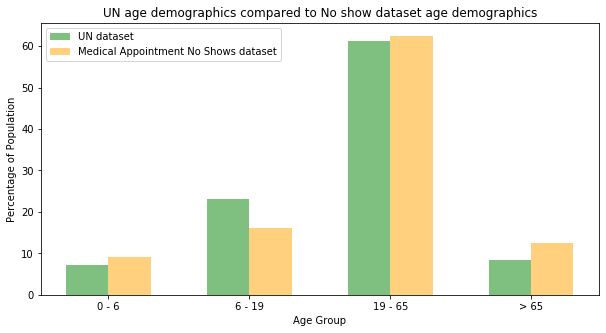

In [44]:
num_of_bars = 4
ind = np.arange(num_of_bars)
width = 0.3
plt.figure(figsize=(10,5))
plt.title('UN age demographics compared to No show dataset age demographics')
plt.xlabel("Age Group")
plt.ylabel("Percentage of Population")
plt.bar(
    ind
    , list(df_un_age_group['percentage'])
    , width
    , label='UN dataset'
    , alpha=0.5
    , color='green'
)
plt.bar(
    ind + width
    , list(df_age_group['percentage'])
    , width
    , label='Medical Appointment No Shows dataset'
    , alpha=0.5
    , color='orange'
)
plt.xticks(ind + width / 2, list(df_un_age_group['age_group']))
plt.legend(loc='best')
plt.show()


#### Analyse Handcap Values 

Handcap values was listed as True or False in the data set documentation but it displays a range of values from 0 - 4.

In [20]:
df_raw.groupby(['handcap']).size()

handcap
0    108286
1      2042
2       183
3        13
4         3
dtype: int64

#### Analyse SMS Received Values 

SMS Received is listed as 1 or more messages sent to the patient but it displays a range of values from 0 - 1.

In [21]:
df_raw.groupby(['sms_received']).size()

sms_received
0    75045
1    35482
dtype: int64

#### Analyse Scheduled Day and Appointment Day

Based on the data definition the appointment_day is supposed to be before the scheduled_day. But it appears that there are a lot of records where the appointment day was after the schedule day. This makes the dates inconsistent for analysing

In [22]:
print(
    f'Schedule day before appointment day count: {df_raw[df_raw["scheduled_day"].dt.date < df_raw["appointment_day"].dt.date]["appointment_id"].count()}'
)

print(
    f'Appointment day before schedule day count: {df_raw[df_raw["scheduled_day"].dt.date > df_raw["appointment_day"].dt.date]["appointment_id"].count()}'
)

print(
    f'Schedule day on appointment day count: {df_raw[df_raw["scheduled_day"].dt.date == df_raw["appointment_day"].dt.date]["appointment_id"].count()}'
)


Schedule day before appointment day count: 71959
Appointment day before schedule day count: 5
Schedule day on appointment day count: 38563


### Data Cleaning

1. Age has a negative value in a single record. The decision is made to remove it since it is removing it is not as impactful since it is only a single record. But guessing the age might cause an invalid count to the other age groups
2. Handcap is showing an expected range of values, since we do not understand the meaning of each value in the range. The decision is made to drop the column.
3. SMS Received is showing an expected range of values, since we do not understand the meaning of each value in the range. The decision is made to drop the column.
4. Appointment day does not happen before the schedule day as described in the data definition. So Appointment day will be dropped from the dataset, we keep Scheduled Date since that acts as a duplicate indicator

#### Check and clean negative age outlier

This operation removes the negative age outlier as it cannot be determined which age group to fit the entry

In [23]:
display(df_raw[df_raw.age < 0])
df_raw.age.replace(-1, np.nan, inplace=True)
display(df_raw[df_raw.age.isna()])
df_raw.dropna(inplace=True)
display(df_raw[df_raw.age.isna()])

,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_group
99832,465943158731293,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,-1,ROMÃO,0,0,0,0,0,0,No,NaN


,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_group
99832,465943158731293,5775010,F,2016-06-06 08:58:13+00:00,2016-06-06 00:00:00+00:00,nan,ROMÃO,0,0,0,0,0,0,No,NaN


,patient_id,appointment_id,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show,age_group


#### Drop Handcap Column

The handcap column is dropped here since it contains data that is does not fit the data dictionary

In [24]:
display(df_raw.info())
df_raw.drop('handcap', axis=1, inplace=True)
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106987 entries, 0 to 110526
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   patient_id       106987 non-null  object             
 1   appointment_id   106987 non-null  object             
 2   gender           106987 non-null  object             
 3   scheduled_day    106987 non-null  datetime64[ns, UTC]
 4   appointment_day  106987 non-null  datetime64[ns, UTC]
 5   age              106987 non-null  float64            
 6   neighbourhood    106987 non-null  object             
 7   scholarship      106987 non-null  int64              
 8   hipertension     106987 non-null  int64              
 9   diabetes         106987 non-null  int64              
 10  alcoholism       106987 non-null  int64              
 11  handcap          106987 non-null  int64              
 12  sms_received     106987 non-null  int64              
 13 

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106987 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   patient_id       106987 non-null  object             
 1   appointment_id   106987 non-null  object             
 2   gender           106987 non-null  object             
 3   scheduled_day    106987 non-null  datetime64[ns, UTC]
 4   appointment_day  106987 non-null  datetime64[ns, UTC]
 5   age              106987 non-null  float64            
 6   neighbourhood    106987 non-null  object             
 7   scholarship      106987 non-null  int64              
 8   hipertension     106987 non-null  int64              
 9   diabetes         106987 non-null  int64              
 10  alcoholism       106987 non-null  int64              
 11  sms_received     106987 non-null  int64              
 12  no_show          106987 non-null  object             
 13 

None

#### Drop SMS Received Column

The SMS Received column is dropped here since it contains data that is does not fit the data dictionary

In [25]:
display(df_raw.info())
df_raw.drop('sms_received', axis=1, inplace=True)
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106987 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   patient_id       106987 non-null  object             
 1   appointment_id   106987 non-null  object             
 2   gender           106987 non-null  object             
 3   scheduled_day    106987 non-null  datetime64[ns, UTC]
 4   appointment_day  106987 non-null  datetime64[ns, UTC]
 5   age              106987 non-null  float64            
 6   neighbourhood    106987 non-null  object             
 7   scholarship      106987 non-null  int64              
 8   hipertension     106987 non-null  int64              
 9   diabetes         106987 non-null  int64              
 10  alcoholism       106987 non-null  int64              
 11  sms_received     106987 non-null  int64              
 12  no_show          106987 non-null  object             
 13 

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106987 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   patient_id       106987 non-null  object             
 1   appointment_id   106987 non-null  object             
 2   gender           106987 non-null  object             
 3   scheduled_day    106987 non-null  datetime64[ns, UTC]
 4   appointment_day  106987 non-null  datetime64[ns, UTC]
 5   age              106987 non-null  float64            
 6   neighbourhood    106987 non-null  object             
 7   scholarship      106987 non-null  int64              
 8   hipertension     106987 non-null  int64              
 9   diabetes         106987 non-null  int64              
 10  alcoholism       106987 non-null  int64              
 11  no_show          106987 non-null  object             
 12  age_group        106987 non-null  category           
dtyp

None

#### Drop Appointment Day Column

The Appointment Day is dropped here since we will not be using it in our study

In [26]:
display(df_raw.info())
df_raw.drop('appointment_day', axis=1, inplace=True)
display(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106987 entries, 0 to 110526
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype              
---  ------           --------------   -----              
 0   patient_id       106987 non-null  object             
 1   appointment_id   106987 non-null  object             
 2   gender           106987 non-null  object             
 3   scheduled_day    106987 non-null  datetime64[ns, UTC]
 4   appointment_day  106987 non-null  datetime64[ns, UTC]
 5   age              106987 non-null  float64            
 6   neighbourhood    106987 non-null  object             
 7   scholarship      106987 non-null  int64              
 8   hipertension     106987 non-null  int64              
 9   diabetes         106987 non-null  int64              
 10  alcoholism       106987 non-null  int64              
 11  no_show          106987 non-null  object             
 12  age_group        106987 non-null  category           
dtyp

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106987 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   patient_id      106987 non-null  object             
 1   appointment_id  106987 non-null  object             
 2   gender          106987 non-null  object             
 3   scheduled_day   106987 non-null  datetime64[ns, UTC]
 4   age             106987 non-null  float64            
 5   neighbourhood   106987 non-null  object             
 6   scholarship     106987 non-null  int64              
 7   hipertension    106987 non-null  int64              
 8   diabetes        106987 non-null  int64              
 9   alcoholism      106987 non-null  int64              
 10  no_show         106987 non-null  object             
 11  age_group       106987 non-null  category           
dtypes: category(1), datetime64[ns, UTC](1), float64(1), int64(4), object(5)


None

#### Drop duplicates in the dataset that displays the same `patient_id` and `scheduled_day`

We clean up the duplicates to prevent double counting

In [27]:
print(f'Record Count before dropping duplicates: {df_raw["patient_id"].count()}')
df_raw.drop_duplicates(['patient_id', 'scheduled_day'], inplace=True)
print(f'Record Count after dropping duplicates: {df_raw["patient_id"].count()}')

Record Count before dropping duplicates: 106987
Record Count after dropping duplicates: 105668


#### Group and count all unique appointments for  `patient_id`  by `no_show` and `show` count

The `no_show` and `show` counts are sum for each patient so that we can perform analysis on a patient level. Since the patient should behave in the same manner and will cause double counting if they are left as inidividual records.

In [28]:
df_patient_no_show_count = df_raw.groupby(['patient_id', 'no_show'])['appointment_id'].count()
df_patient_no_show_count = df_patient_no_show_count.add_suffix('').reset_index()
df_patient_no_show_count = df_patient_no_show_count.pivot(index='patient_id', columns='no_show', values='appointment_id')
df_patient_no_show_count.reset_index(inplace=True)
df_patient_no_show_count.fillna(0, inplace=True)
df_patient_no_show_count.rename(
    columns={
        'patient_id': 'no_show_patient_id',
        'No': 'no_show_count',
        'Yes': 'show_count',
    }, inplace=True
)

df_patient_no_show_count = df_patient_no_show_count.astype({
    'no_show_count': 'int32',
    'show_count': 'int32'
})

df_patient_no_show_count['total_appointments'] = (
    df_patient_no_show_count['no_show_count'] + df_patient_no_show_count['show_count']
)

df_patient_no_show_count['no_show_percentage'] = (
    100 * df_patient_no_show_count['no_show_count'] / df_patient_no_show_count['total_appointments']
)

no_show_percentage_labels = [ '0% - 25%', '26% - 50%', '51 - 75%', '76% - 100%' ]

df_patient_no_show_count['no_show_percentage_group'] = pd.cut(
    df_patient_no_show_count.no_show_percentage,
    bins=4,
    labels=no_show_percentage_labels
)

df_patient_no_show_count

no_show,no_show_patient_id,no_show_count,show_count,total_appointments,no_show_percentage,no_show_percentage_group
0,11111462625267,1,0,1,100.00000,76% - 100%
1,111124532532143,1,1,2,50.00000,26% - 50%
2,11114485119737,0,1,1,0.00000,0% - 25%
3,11116239871275,1,0,1,100.00000,76% - 100%
4,1111633122891,3,0,3,100.00000,76% - 100%
...,...,...,...,...,...,...
60265,999968578354866,1,0,1,100.00000,76% - 100%
60266,9999737245272,1,1,2,50.00000,26% - 50%
60267,999981631772427,1,0,1,100.00000,76% - 100%
60268,9999951146446,0,2,2,0.00000,0% - 25%


#### Drop multiple records for same patient

This operation completes the group of the appointments on a patient level by dropping the columns that caused the patient to be duplicated

In [29]:
display(df_raw.info())
df_raw.drop(['appointment_id', 'scheduled_day', 'no_show'], axis=1, inplace=True)
display(df_raw.info())

print(f'Record Count before dropping duplicates: {df_raw["patient_id"].count()}')
df_raw.drop_duplicates(['patient_id'], inplace=True)
print(f'Record Count after dropping duplicates: {df_raw["patient_id"].count()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105668 entries, 0 to 110526
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   patient_id      105668 non-null  object             
 1   appointment_id  105668 non-null  object             
 2   gender          105668 non-null  object             
 3   scheduled_day   105668 non-null  datetime64[ns, UTC]
 4   age             105668 non-null  float64            
 5   neighbourhood   105668 non-null  object             
 6   scholarship     105668 non-null  int64              
 7   hipertension    105668 non-null  int64              
 8   diabetes        105668 non-null  int64              
 9   alcoholism      105668 non-null  int64              
 10  no_show         105668 non-null  object             
 11  age_group       105668 non-null  category           
dtypes: category(1), datetime64[ns, UTC](1), float64(1), int64(4), object(5)


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105668 entries, 0 to 110526
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   patient_id     105668 non-null  object  
 1   gender         105668 non-null  object  
 2   age            105668 non-null  float64 
 3   neighbourhood  105668 non-null  object  
 4   scholarship    105668 non-null  int64   
 5   hipertension   105668 non-null  int64   
 6   diabetes       105668 non-null  int64   
 7   alcoholism     105668 non-null  int64   
 8   age_group      105668 non-null  category
dtypes: category(1), float64(1), int64(4), object(3)
memory usage: 7.4+ MB


None

Record Count before dropping duplicates: 105668
Record Count after dropping duplicates: 60270


#### Merge to get Show and No-Show Count

This operation merges the `show` and `no-show` counts back to the dataset for analysing the appointment `show` and `no-show` reasons

In [30]:
#columns = df_raw.columns
columns = [
    column for column in df_patient_no_show_count.columns if column != 'no_show_patient_id'
]
columns = [
    column for column_group in [
        df_raw.columns, df_patient_no_show_count.columns
    ] for column in column_group if column != 'no_show_patient_id'
] 

df_transform = df_raw.merge(
    df_patient_no_show_count
    , left_on='patient_id'
    , right_on='no_show_patient_id'
)[
    columns
]

df_transform.head()

,patient_id,gender,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,age_group,no_show_count,show_count,total_appointments,no_show_percentage,no_show_percentage_group
0,29872499824296,F,62.00000,JARDIM DA PENHA,0,1,0,0,19 - 65,2,0,2,100.00000,76% - 100%
1,558997776694438,M,56.00000,JARDIM DA PENHA,0,0,0,0,19 - 65,2,0,2,100.00000,76% - 100%
2,4262962299951,F,62.00000,MATA DA PRAIA,0,0,0,0,19 - 65,2,0,2,100.00000,76% - 100%
3,867951213174,F,8.00000,PONTAL DE CAMBURI,0,0,0,0,6 - 19,1,1,2,50.00000,26% - 50%
4,8841186448183,F,56.00000,JARDIM DA PENHA,0,1,1,0,19 - 65,1,0,1,100.00000,76% - 100%


### Summary Statistics

The new data set shows a drop in the record counts that shows that duplicate records are removed. The columns neighbourhood, scholarship, hipertension and diabetes also do not display  any percentile values which is logical since they are binary values. A further check into neighbourhood, scholarship, hipertension and diabetes show that the population leans towards the 0 value which makes them difficult to be analyzed for this project. 

In [50]:
display(df_transform.describe())

display(df_transform.groupby('scholarship')['patient_id'].count())
display(df_transform.groupby('hipertension')['patient_id'].count())
display(df_transform.groupby('diabetes')['patient_id'].count())
display(df_transform.groupby('alcoholism')['patient_id'].count())

,age,scholarship,hipertension,diabetes,alcoholism,no_show_count,show_count,total_appointments,no_show_percentage
count,60270.00000,60270.00000,60270.00000,60270.00000,60270.00000,60270.00000,60270.00000,60270.00000,60270.00000
mean,37.94133,0.09552,0.20312,0.07327,0.02499,1.40105,0.35220,1.75324,80.34590
std,22.92219,0.29393,0.40232,0.26058,0.15609,1.62055,0.67316,1.76214,35.16695
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
25%,18.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,66.66667
50%,38.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,100.00000
75%,56.00000,0.00000,0.00000,0.00000,0.00000,2.00000,1.00000,2.00000,100.00000
max,115.00000,1.00000,1.00000,1.00000,1.00000,87.00000,18.00000,88.00000,100.00000


scholarship
0    54513
1     5757
Name: patient_id, dtype: int64

hipertension
0    48028
1    12242
Name: patient_id, dtype: int64

diabetes
0    55854
1     4416
Name: patient_id, dtype: int64

alcoholism
0    58764
1     1506
Name: patient_id, dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis

### Research Question: Does Gender play a part in the show and no-show probability

Based on looking into the unique patient's gender and the percentage of the patient being a no-show. It appears that gender does not impact in the behavior of showing up for the medical appointment.

1. 76% - 100% no show rate: Displayed by around 70% for both Male and Female
2. 51% - 75% no show rate: Displayed by around 5-7% for both Male and Female
3. 26% - 50% no show rate: Displayed by around 8-10% for both Male and Female
4. 0% - 25% no show rate: Displayed by around 10-14% for both Male and Female

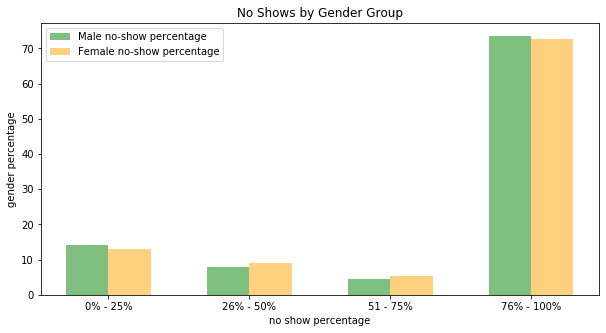

In [43]:
def get_gender_percentage(df, gender):
    df_result = df[df['gender'] == gender].copy(deep=True)
    total_gender_population = df_result['count'].sum()
    df_result['gender_percentage'] = (
        100 * df_result['count'] / total_gender_population
    )
    return df_result
    
df_gender_percentage = df_transform.groupby(['no_show_percentage_group', 'gender'])['patient_id'].count().reset_index()
df_gender_percentage.rename(columns={"patient_id": "count"}, inplace=True)

df_male_percentage = get_gender_percentage(df_gender_percentage, 'M')
df_female_percentage = get_gender_percentage(df_gender_percentage, 'F')

num_of_bars = 4
ind = np.arange(num_of_bars)
width = 0.3
plt.figure(figsize=(10,5))
plt.title('No Shows by Gender Group')
plt.xlabel('no show percentage')
plt.ylabel('gender percentage')
plt.bar(
    ind
    , list(df_male_percentage['gender_percentage'])
    , width
    , label='Male no-show percentage'
    , alpha=0.5
    , color='green'    
)
plt.bar(
    ind + width
    , list(df_female_percentage['gender_percentage'])
    , width
    , label='Female no-show percentage'
    , alpha=0.5
    , color='orange'    
)
plt.xticks(ind + width / 2, list(df_gender_percentage['no_show_percentage_group'].unique()))
plt.legend(loc='best')
plt.show()

### Research Question 2: Does Age Group play a part in the show and no-show probability

Looking into the results it appears that there is a slight increase with no-show for the elderly and preschool groups. It might be worth looking more into other factors in these groups that might reveal the reasons for the no-shows.

1. 76% - 100% no show: 75% - 80% of elderly and preschool

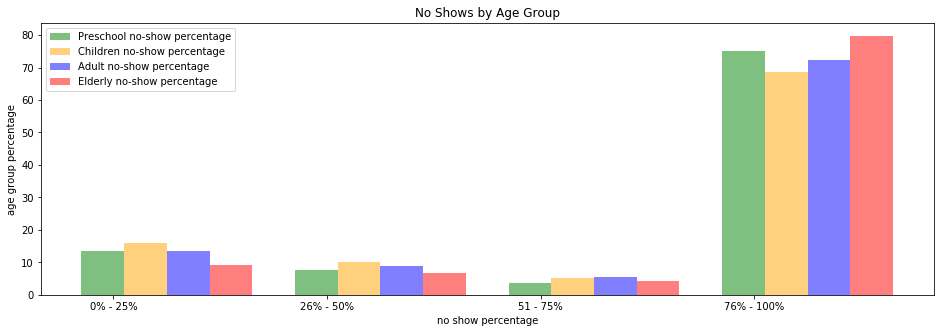

In [51]:
def get_age_group_percentage(df, age_group):
    df_result = df[df['age_group'] == age_group].copy(deep=True)
    total_age_group_population = df_result['count'].sum()
    df_result['age_group_percentage'] = (
        100 * df_result['count'] / total_age_group_population
    )
    return df_result
    
df_age_group_percentage = df_transform.groupby(['no_show_percentage_group', 'age_group'])['patient_id'].count().reset_index()
df_age_group_percentage.rename(columns={"patient_id": "count"}, inplace=True)
df_preschool_group_percentage = get_age_group_percentage(df_age_group_percentage, '0 - 6')
df_children_group_percentage = get_age_group_percentage(df_age_group_percentage, '6 - 19')
df_adult_group_percentage = get_age_group_percentage(df_age_group_percentage, '19 - 65')
df_elderly_group_percentage = get_age_group_percentage(df_age_group_percentage, '> 65')

num_of_bars = 4
ind = np.arange(num_of_bars)
width = 0.2
plt.figure(figsize=(16,5))
plt.title('No Shows by Age Group')
plt.xlabel('no show percentage')
plt.ylabel('age group percentage')
plt.bar(
    ind
    , list(df_preschool_group_percentage['age_group_percentage'])
    , width
    , label='Preschool no-show percentage'
    , alpha=0.5
    , color='green'    
)
plt.bar(
    ind + width
    , list(df_children_group_percentage['age_group_percentage'])
    , width
    , label='Children no-show percentage'
    , alpha=0.5
    , color='orange'    
)
plt.bar(
    ind + (2 * width)
    , list(df_adult_group_percentage['age_group_percentage'])
    , width
    , label='Adult no-show percentage'
    , alpha=0.5
    , color='blue'    
)
plt.bar(
    ind + (3 * width)
    , list(df_elderly_group_percentage['age_group_percentage'])
    , width
    , label='Elderly no-show percentage'
    , alpha=0.5
    , color='red'    
)
plt.xticks(
    ind + width / 4
    , list(df_age_group_percentage['no_show_percentage_group'].unique())
)
plt.legend(loc='best')
plt.show()

<a id='conclusions'></a>
## Conclusions

For the analysis of the data, we observe the following:

1. little relation between the no-shows and gender. 
2. Looking into the no-show percentage against the age groups though revealed some age groups display increases in no shows that might be worth exploring.

### Limitations

1. No data on the characteristics of the Age Groups that might help with identifying the reason behind slightly higher No show rates for the preschool and elderly group.
2. No relationship information about the patients that will be help in checking if certain groups might be impacted by the no-show behavior of other groups. An example will be Pre-school group which will be impacted by the behavior of the parents since most of the pre school group requires an adult to help them make the appointment.
3. Interesting features that might impact no show rate like scholarship, hipertension, diabetes and	alcoholism were not studied as the distribution of those data appear to be leaning towards one side of the measure.

In [34]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0